In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

In [19]:
import tensorflow as tf

# Create three independent generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  # don't shuffle for evaluation/prediction
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [26]:

def scr(x):
    C = x.shape[-1]
    # Convolution on input
    y = Conv2D(C, (3,3), padding='same', activation='relu')(x)

    # Split channels
    c_half = C // 2
    x1, x2 = Lambda(lambda z: tf.split(z, [c_half, C - c_half], axis=-1))(x)
    y1, y2 = Lambda(lambda z: tf.split(z, [c_half, C - c_half], axis=-1))(y)

    # Cross concatenation
    x_concat = Concatenate()([x1, y2])
    y_concat = Concatenate()([y1, x2])

    # Convolution + BN + ReLU
    x_sc = Conv2D(C, (3,3), padding='same')(x_concat)
    x_sc = BatchNormalization()(x_sc)
    x_sc = Activation('relu')(x_sc)

    y_sc = Conv2D(C, (3,3), padding='same')(y_concat)
    y_sc = BatchNormalization()(y_sc)
    y_sc = Activation('relu')(y_sc)

    # Channel gating
    x_int = GlobalAveragePooling2D()(x_sc)
    x_int = Dense(C, activation='sigmoid')(x_int)
    x_int = Reshape((1,1,C))(x_int)
    x_out = Multiply()([x_int, x_sc])

    y_int = GlobalAveragePooling2D()(y_sc)
    y_int = Dense(C, activation='sigmoid')(y_int)
    y_int = Reshape((1,1,C))(y_int)
    y_out = Multiply()([y_int, y_sc])

    # Residual addition
    out = Add()([x_out, y_out, x])
    return out
def fcn(x, num_classes=4):
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return output



def RCCGnet(input_shape=(1024,1024,3), num_classes=4):
    input_layer = Input(shape=input_shape)

    # Conv + Pool (Stage 1)
    x = Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu')(input_layer)
    x=scr(x)
    x=scr(x)
    x = Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x=scr(x)
    x=scr(x)
    x = Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x=scr(x)
    x=scr(x)
    output = fcn(x, num_classes=4)
    
    model =Model(inputs=input_layer, outputs=output)
    return model

model = RCCGnet()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 512, 512, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 512, 512, 16) 2320        conv2d_66[0][0]                  
__________________________________________________________________________________________________
lambda_36 (Lambda)              [(None, 512, 512, 8) 0           conv2d_66[0][0]                  
____________________________________________________________________________________________

In [9]:
from tensorflow.keras.optimizers import Adam

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_delta=0.0001
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


check_path = '/content/drive/MyDrive/rccgnet2.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)


# Fit the model
hist_scratch =model.fit(
    train_generator,
    validation_data=val_generator,  # ✅ use val_generator, not test_generator
    epochs=65,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/65
417/417 [==============================] - 60s 140ms/step - loss: 0.4566 - accuracy: 0.8044 - val_loss: 2.9852 - val_accuracy: 0.3399

Epoch 00001: val_accuracy improved from -inf to 0.33994, saving model to /content/drive/MyDrive\rccgnet2.weights.h5
Epoch 2/65
417/417 [==============================] - 59s 140ms/step - loss: 0.4185 - accuracy: 0.8185 - val_loss: 0.6187 - val_accuracy: 0.7523

Epoch 00002: val_accuracy improved from 0.33994 to 0.75235, saving model to /content/drive/MyDrive\rccgnet2.weights.h5
Epoch 3/65
417/417 [==============================] - 58s 140ms/step - loss: 0.4112 - accuracy: 0.8245 - val_loss: 2.3127 - val_accuracy: 0.4859

Epoch 00003: val_accuracy did not improve from 0.75235
Epoch 4/65
417/417 [==============================] - 59s 141ms/step - loss: 0.4192 - accuracy: 0.8192 - val_loss: 1.0504 - val_accuracy: 0.5631

Epoch 00004: val_accuracy did not improve from 0.75235
Epoch 5/65
417/417 [==============================] - 59s 142ms/step - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0, 0.5, 'Loss')

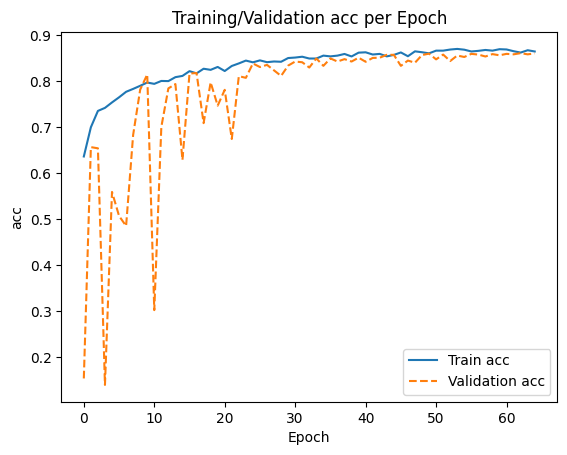

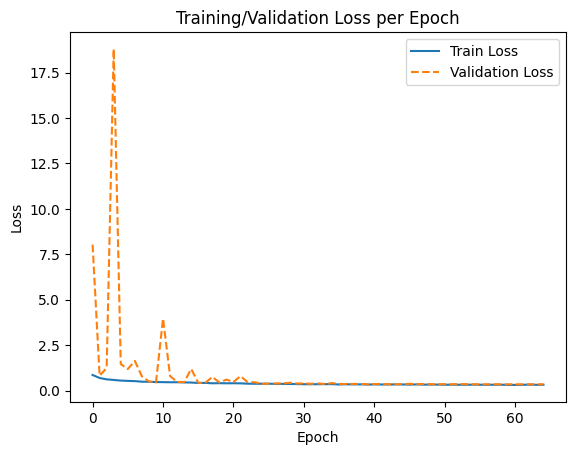

In [27]:
# Plot the model accuracy on training and validation data
print(hist_scratch.history.keys())

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['accuracy'])
ax.plot(hist_scratch.history['val_accuracy'], '--')
ax.legend(['Train acc', 'Validation acc'])
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

# Plot the model loss on training and validation data
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['loss'], )
ax.plot(hist_scratch.history['val_loss'], '--')
ax.legend(['Train Loss', 'Validation Loss'])
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [11]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'A': 0, 'B': 1, 'C': 2, 'D': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[0 0 0 ... 3 3 3]


In [12]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.8662026295436969
F1 0.848738297520375
precision 0.8444460804847385
recall 0.8542553953638619
jaccard 0.744392366509224
classification_report
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       466
           1       0.75      0.80      0.78       233
           2       0.82      0.83      0.83       411
           3       0.80      0.85      0.82       183

    accuracy                           0.87      1293
   macro avg       0.84      0.85      0.85      1293
weighted avg       0.87      0.87      0.87      1293




[[437  11   1  17]
 [  0 187  44   2]
 [  0  51 341  19]
 [  0   0  28 155]]


In [14]:
from tensorflow.keras.optimizers import Adam

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_delta=0.0001
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


check_path = '/content/drive/MyDrive/rccgnet2.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)


# Fit the model
hist_scratch =model.fit(
    train_generator,
    validation_data=val_generator,  # ✅ use val_generator, not test_generator
    epochs=65,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/65
417/417 [==============================] - 61s 141ms/step - loss: 0.8596 - accuracy: 0.6360 - val_loss: 8.0359 - val_accuracy: 0.1533

Epoch 00001: val_accuracy improved from -inf to 0.15328, saving model to /content/drive/MyDrive\rccgnet2.weights.h5
Epoch 2/65
417/417 [==============================] - 58s 138ms/step - loss: 0.6949 - accuracy: 0.6995 - val_loss: 0.8163 - val_accuracy: 0.6564

Epoch 00002: val_accuracy improved from 0.15328 to 0.65641, saving model to /content/drive/MyDrive\rccgnet2.weights.h5
Epoch 3/65
417/417 [==============================] - 57s 135ms/step - loss: 0.6191 - accuracy: 0.7351 - val_loss: 1.2524 - val_accuracy: 0.6538

Epoch 00003: val_accuracy did not improve from 0.65641
Epoch 4/65
417/417 [==============================] - 57s 136ms/step - loss: 0.5865 - accuracy: 0.7417 - val_loss: 18.8034 - val_accuracy: 0.1392

Epoch 00004: val_accuracy did not improve from 0.65641
Epoch 5/65
417/417 [==============================] - 57s 136ms/step -